In [14]:
import numpy as np
import matplotlib.pyplot as plt

# https://www.kaggle.com/datasets/harishkumardatalab/housing-price-prediction/data
# Load data
data = np.loadtxt(
    './Housing.csv',
    delimiter=',',
    skiprows=1,
    dtype=[
        ('price', 'float'),
        ('area', 'float'),
        ('bedrooms', 'float'),
        ('bathrooms', 'float'),
        ('stories', 'float'),
        ('mainroad', 'U3'),
        ('guestroom', 'U3'),
        ('basement', 'U3'),
        ('hotwaterheating', 'U3'),
        ('airconditioning', 'U3'),
        ('parking', 'float'),
        ('prefarea', 'U3'),
        ('furnishingstatus', 'U30')
    ]
)

In [15]:
data[0]

(13300000., 7420., 4., 2., 3., 'yes', 'no', 'no', 'no', 'yes', 2., 'yes', 'furnished')

In [16]:
encode = lambda x, string: 1. if x == string else 0.
encode_yes_no = lambda x: encode(x, 'yes')
encode_furnish_none = lambda x: encode(x, 'unfurnished')
encode_furnish_semi = lambda x: encode(x, 'semi-furnished')
encode_furnish_full = lambda x: encode(x, 'furnished')

def convert_data(raw_data):
    x_train = []
    y_train = []
    price_index = 0

    for house in raw_data:
        (
            price,
            area,
            bedrooms,
            bathrooms,
            stories,
            mainroad,
            guestroom,
            basement,
            hotwaterheating,
            airconditioning,
            parking,
            prefarea,
            furnishingstatus
        ) = house

        # price (millions)
        price /= 1e6

        # area (thousands of square feet)
        area /= 1e3
        
        y_train.append(price)
        mainroad = encode_yes_no(mainroad)
        guestroom = encode_yes_no(guestroom)
        basement = encode_yes_no(basement)
        hotwaterheating = encode_yes_no(hotwaterheating)
        airconditioning = encode_yes_no(airconditioning)
        prefarea = encode_yes_no(prefarea)

        # Perform one-hot encoding for features with more than 2 values
        furnish_none = encode_furnish_none(furnishingstatus)
        furnish_semi = encode_furnish_semi(furnishingstatus)
        furnish_full = encode_furnish_full(furnishingstatus)

        x_train.append([
            area,
            bedrooms,
            bathrooms,
            stories,
            mainroad,
            guestroom,
            basement,
            hotwaterheating,
            airconditioning,
            parking,
            prefarea,
            furnish_none,
            furnish_semi,
            furnish_full,
        ])
        

    return np.array(x_train), np.array(y_train)
    

In [17]:
x_train, y_train = convert_data(data)
for i in range(5):
    print(x_train[i])

[7.42 4.   2.   3.   1.   0.   0.   0.   1.   2.   1.   0.   0.   1.  ]
[8.96 4.   4.   4.   1.   0.   0.   0.   1.   3.   0.   0.   0.   1.  ]
[9.96 3.   2.   2.   1.   0.   1.   0.   0.   2.   1.   0.   1.   0.  ]
[7.5 4.  2.  2.  1.  0.  1.  0.  1.  3.  1.  0.  0.  1. ]
[7.42 4.   1.   2.   1.   1.   1.   0.   1.   2.   0.   0.   0.   1.  ]


In [18]:
from sklearn.linear_model import SGDRegressor
skx_norm=x_train

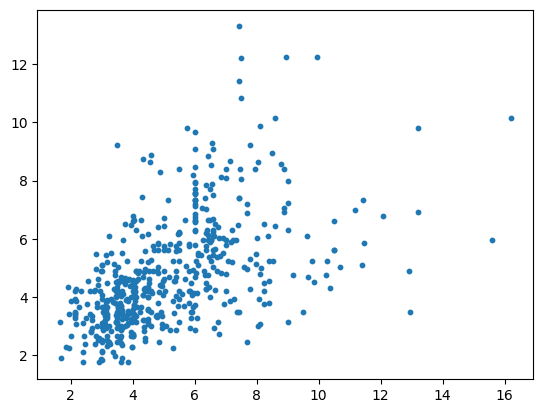

In [19]:
# Visualize some relationships
fig, ax = plt.subplots()

x_area = skx_norm[:, 0]
ax.scatter(x_area, y_train, s=10)

In [20]:
sgdr = SGDRegressor(max_iter=10000)
sgdr.fit(skx_norm, y_train)
print(sgdr)
print(f"Iterations: {sgdr.n_iter_}, Weights updated: {sgdr.t_}")

SGDRegressor(max_iter=10000)
Iterations: 30, Weights updated: 16351.0


In [21]:
b_norm = sgdr.intercept_[0]
w_norm = sgdr.coef_
print(f"w: {w_norm}, b:{b_norm}")

w: [ 0.21728791  0.08660013  0.95876616  0.46613527  0.35862269  0.30704089
  0.36739745  0.45301031  0.81058691  0.28323172  0.62471256 -0.26976477
  0.10846886  0.16356856], b:0.0023597764320747484


In [22]:
y_pred = []

for i in range(len(x_train)):
    y_pred.append(w_norm @ x_train[i] + b_norm)

Text(0, 0.5, 'Price (millions)')

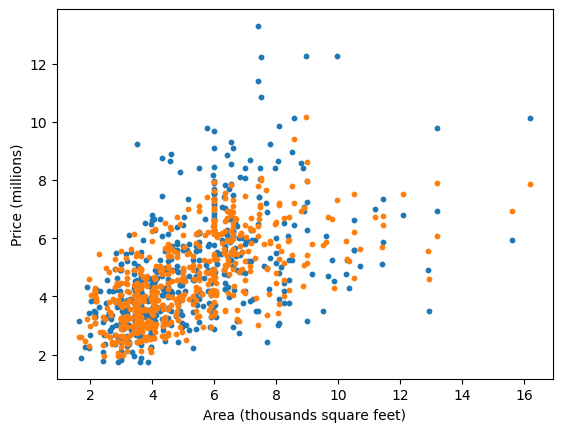

In [23]:
# Visualize some relationships
fig, ax = plt.subplots()

x_area = skx_norm[:, 0]
ax.scatter(x_area, y_train, s=10)
ax.scatter(x_area, y_pred, s=10)
ax.set_xlabel('Area (thousands square feet)')
ax.set_ylabel('Price (millions)')

The linear model catches the most populated area very well, but does poorly for outliers.

In [217]:
# Python implementation
def f(x, w, b):
    return w @ x + b

def j(x_train, y_train, w, b):
    # Mean-squared error
    return 1/(2*x_train.shape[0]) * np.sum(
        np.square([
            f(x, w, b) - y_train[i]
            for i, x in enumerate(x_train)
        ])
    )

def gradients(x_train, y_train, w, b):
    m = x_train.shape[0]
    dj_dw = 1/m * np.sum(
        [
            (f(x, w, b) - y_train[i]) * x 
            for i, x in enumerate(x_train)
        ],
        0 # set dimension to 0. numpy will sum all matrixes and return a matrix instead of scalar
    )

    dj_db = 1/m * np.sum(
        [
            f(w, x, b) - y_train[i]
            for i, x in enumerate(x_train)
        ]
    )

    return dj_dw, dj_db

def fit(x_train, y_train, w, b, learning_rate, num_iter, epsilon = None):
    costs = []
    for i in range(num_iter + 1):
        dj_dw, dj_db = gradients(x_train, y_train, w, b)

        w -= learning_rate * dj_dw
        b -= learning_rate * dj_db

        cost = j(x_train, y_train, w, b)
        
        costs.append(cost)

        if epsilon != None and cost < epsilon:
            print (f'Converged after {i} iteration')
            break
        
        if i % 200 == 0:
            print(f'[{i}] {cost}')

    return costs, w, b

In [218]:
w_init = np.array(np.random.uniform(0, 20, size=x_train.shape[1]))
b_init = np.random.uniform(0, 20)
learning_rate = 4e-2
num_iter = 2000
epsilon = None

costs, w, b = fit(x_train, y_train, w_init, b_init, learning_rate, num_iter, epsilon)

[0] 16007.111935561441
[200] 4.735756907819568
[400] 1.7572255156428742
[600] 1.1349446429396748
[800] 0.8520136830198912
[1000] 0.7085107859570452
[1200] 0.6346148320163032
[1400] 0.5964504598480562
[1600] 0.5767234972054053
[1800] 0.5665232151997902
[2000] 0.5612478781071113


Text(0, 0.5, 'Price (millions)')

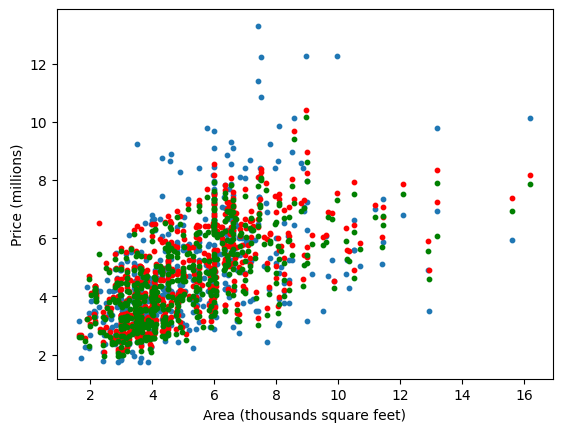

In [219]:
y_pred=[f(x, w, b) for x in x_train]
y_sgdr=[f(x, w_norm, b_norm) for x in x_train]

# Visualize some relationships
fig, ax = plt.subplots()

x_area = x_train[:, 0]
ax.scatter(x_area, y_train, s=10)
ax.scatter(x_area, y_pred, s=10, c='red')
ax.scatter(x_area, y_sgdr, s=10, c='green')
ax.set_xlabel('Area (thousands square feet)')
ax.set_ylabel('Price (millions)')

The result of our implementation is close to that of `SGDRegressor`